In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn 
import plotly.express as px
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [70]:
df = pd.read_csv('amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

1) Посмотрим признаки объектов датасета.

In [71]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

2) Посмотрим долю пропусков в признаках к количеству объектов.

In [72]:
rows = max(df[i].size for i in df.columns)
print(rows)
df.isna().sum().apply(lambda v: 100.0 * v / rows)

10000


manufacturer                         0.07
price                               14.35
number_available_in_stock           25.00
number_of_reviews                    0.18
number_of_answered_questions         7.65
average_review_rating                0.18
amazon_category_and_sub_category     6.90
dtype: float64

3) Оказалось, что в number_available_in_stock четверть данных отсутствует. Возможно, стоит не учитывать этот признак, чтобы не запутывать модель.

In [73]:
df = df.drop(columns=['number_available_in_stock'])

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   manufacturer                      9993 non-null   object 
 1   price                             8565 non-null   object 
 2   number_of_reviews                 9982 non-null   object 
 3   number_of_answered_questions      9235 non-null   float64
 4   average_review_rating             9982 non-null   object 
 5   amazon_category_and_sub_category  9310 non-null   object 
dtypes: float64(1), object(5)
memory usage: 468.9+ KB


Итак, нужно закодировать данные. 

In [75]:
df.amazon_category_and_sub_category.value_counts()

amazon_category_and_sub_category
Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles    880
Figures & Playsets > Science Fiction & Fantasy                                     485
Arts & Crafts > Children's Craft Kits > Bead Art & Jewellery-Making                368
Characters & Brands > Disney > Toys                                                347
Hobbies > Trading Cards & Accessories > Packs & Sets                               317
                                                                                  ... 
Hobbies > Model Trains & Railway Sets                                                1
Cooking & Dining > Kitchen Tools & Gadgets > Barware > Coasters                      1
Women > Accessories > Eyewear & Accessories > Sunglasses                             1
Hobbies > Model Trains & Railway Sets > Accessories                                  1
Games > Drinking Games                                                               1
Name: coun

Категория amazon_category_and_sub_category, как видно, имеет подкатегории. Найдем их количество:

In [76]:
l = 0
for i in df.amazon_category_and_sub_category:
    try:
        l_ = len(i.split(' > '))
        if l < l_:
            l = l_
    except:
        continue

print(l)

5


Их оказалось 5, теперь заменим amazon_category_and_sub_category за 5 признаков - категория и подкатегории этого признака. Если длина цепочки будет меньше 5, то заполним оставшиеся значения 'пропусками' - 'space'. 

In [77]:
def categorize(s: str):
    categories = []
    try:
        categories = s.split(' > ')
    except:
        pass
    while len(categories) < 5:
        categories.append(np.nan)

    return categories

subcategories = df.amazon_category_and_sub_category.apply(lambda v : categorize(v))
df = df.drop(columns=['amazon_category_and_sub_category'])

subcategories.value_counts()

#subc_columns = pd.DataFrame(columns=['1', '2', '3', '4', '5'], index=df.index)

for i in range(5):
    df[str(i + 1)] = [sc[i] for sc in subcategories]
    

df.head()

,manufacturer,price,number_of_reviews,number_of_answered_questions,average_review_rating,1,2,3,4,5
0,Hornby,£3.42,15,1.0,4.9 out of 5 stars,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
1,FunkyBuys,£16.99,2,1.0,4.5 out of 5 stars,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
2,ccf,£9.99,17,2.0,3.9 out of 5 stars,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
3,Hornby,£39.99,1,2.0,5.0 out of 5 stars,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN
4,Hornby,£32.19,3,2.0,4.7 out of 5 stars,Hobbies,Model Trains & Railway Sets,Rail Vehicles,Trains,NaN


Итак, теперь закодируем все колонки

In [78]:
encoder = OrdinalEncoder()

# subcategories
for i in range(5):
    df[str(i + 1)] = encoder.fit_transform(df[[str(i + 1)]])

# manufacturer
df['manufacturer'] = encoder.fit_transform(df[['manufacturer']])

# price
def code_price(s):
    try:
        s = s.replace(',', '')
        s = s[1:]
        return float(s)
    except:
        return np.nan

df['price'] = df['price'].apply(lambda p : code_price(p))

df.price.value_counts()

# rating
def get_rating(s: str):
    try:
        s = s[:3]
        return float(s)
    except:
        return np.nan

df['average_review_rating'] = df.average_review_rating.apply(lambda p: get_rating(p))

df['number_of_reviews'].isna().any()

# number_of_reviews

def to_float(s):
    try:
        s = s.replace(',', '')
        return float(s)
    except:
        return np.nan
    
df['number_of_reviews'] = df.number_of_reviews.apply(lambda n : to_float(n))


print(df.head())

   manufacturer  price  number_of_reviews  number_of_answered_questions   
0        1029.0   3.42               15.0                           1.0  \
1         801.0  16.99                2.0                           1.0   
2        2555.0   9.99               17.0                           2.0   
3        1029.0  39.99                1.0                           2.0   
4        1029.0  32.19                3.0                           2.0   

   average_review_rating     1     2     3     4   5  
0                    4.9  18.0  90.0  81.0  39.0 NaN  
1                    4.5  18.0  90.0  81.0  39.0 NaN  
2                    3.9  18.0  90.0  81.0  39.0 NaN  
3                    5.0  18.0  90.0  81.0  39.0 NaN  
4                    4.7  18.0  90.0  81.0  39.0 NaN  


Уберем строчки, в которых много пропусков. Возможно, стоит удалять строчки, в которых ненановских значений меньше половины (всего колонок 10)

In [79]:
df = df[df.isna().sum(axis=1) < 5]

Осталось заменить пропуски в значениях средними по колонкам

In [80]:
for column in df.columns:
    #print(column, df[column].mean())
    df.loc[df[column].isna(), column] = df[~df[column].isna()][column].mean()

df.isna().any().any()

False

In [81]:
df.value_counts()

manufacturer  price     number_of_reviews  number_of_answered_questions  average_review_rating  1     2      3           4          5       
2037.0        20.15037  1.0                1.00000                       5.0                    6.0   126.0  105.000000  35.335004  1.270588    8
480.0         20.15037  1.0                1.00000                       5.0                    8.0   138.0  84.000000   41.000000  1.270588    7
601.0         20.15037  1.0                1.00000                       5.0                    6.0   44.0   105.000000  35.335004  1.270588    7
21.0          15.00000  1.0                1.00000                       5.0                    35.0  65.0   63.833271   35.335004  1.270588    6
979.0         20.15037  1.0                1.00000                       5.0                    6.0   68.0   63.833271   35.335004  1.270588    6
                                                                                                                                 

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [82]:
X = df.drop(columns= 'price'); y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

dr = DummyRegressor()

dr.fit(X_train, y_train)

y_pred = dr.predict(X_test)

y_pred

array([19.6559547, 19.6559547, 19.6559547, ..., 19.6559547, 19.6559547,
       19.6559547])

Посчитаем оценки:

In [83]:
def scores(y_test, y_pred):
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test, y_pred)
    print(f"MSE = {MSE}, RMSE = {RMSE}  R2 = {R2}")

scores(y_test, y_pred)

MSE = 3407.3375125633847, RMSE = 58.37240369012899  R2 = -0.0006589788026318821


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [84]:
reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

y_pred = reg_tree.predict(X_test)

print(y_pred)

scores(y_test, y_pred)

[ 4.975       8.6        12.695      ... 20.15037046 14.43391537
 20.15037046]
MSE = 4466.180251676925, RMSE = 66.82948639393337  R2 = -0.3116174588848797


Качество модели ухудшилось, показатель abs(R2) увеличился.

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [85]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print(y_pred)

scores(y_test, y_pred)

[14.10649875 17.59924263 24.09432193 ... 24.15887415 23.01042052
 29.28596507]
MSE = 3373.875723854448, RMSE = 58.08507315872511  R2 = 0.009168001704856432


# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [86]:
import seaborn as sns


def plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        # инициализация объекта из словаря
        # распаковка словаря через ** эквивалентна перечислению аргументов
        model = DecisionTreeRegressor(**{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
        test_curve.append(np.sqrt(mean_squared_error(y_test, y_pred_test)))
    sns.lineplot(x=values, y=train_curve, label='train')
    sns.lineplot(x=values, y=test_curve, label='test')

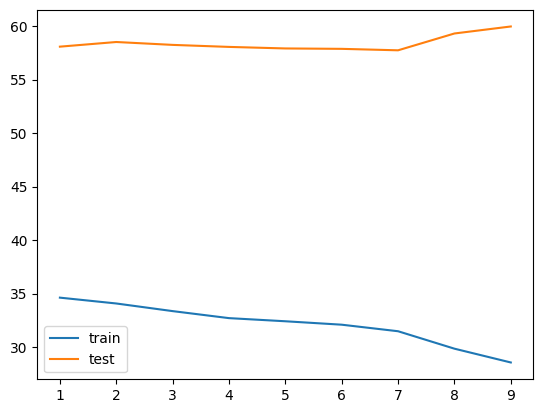

In [87]:
plot_fitting_curve('max_depth', np.arange(1, 10), X_train, X_test, y_train, y_test)

Для глубины лучшее значение - это 7, т.к. после модель переобучается и начинает выдавать результаты хуже.

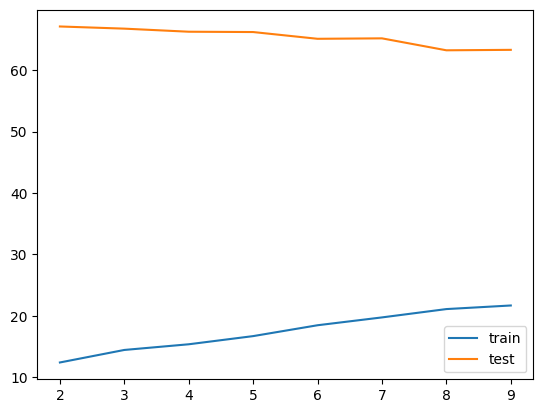

In [88]:
plot_fitting_curve('min_samples_split', np.arange(2, 10), X_train, X_test, y_train, y_test)

Тут 6

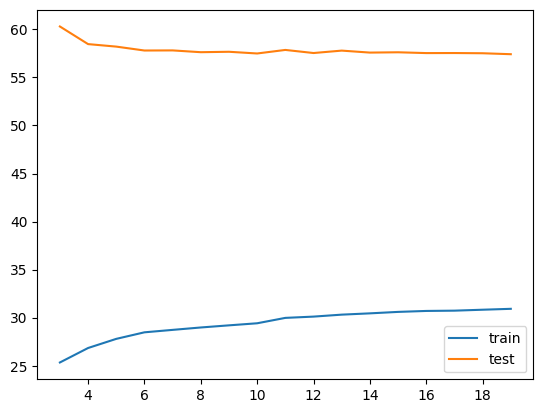

In [89]:
plot_fitting_curve('min_samples_leaf', np.arange(3, 20), X_train, X_test, y_train, y_test)

Тут 10

In [90]:
tree_par = DecisionTreeRegressor(max_depth=7, min_samples_split=6, min_samples_leaf=10)
tree_par.fit(X_train, y_train)
y_pred = tree_par.predict(X_test)

scores(y_test, y_pred)

MSE = 3286.747684664834, RMSE = 57.330163829042334  R2 = 0.03475556219720222


Стало чуть-чуть да лучше)

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [95]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(x, y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.